In [1]:
!git clone -b week9-dev https://github.com/vamsigp/EVA5/

Cloning into 'EVA5'...
remote: Enumerating objects: 352, done.
remote: Counting objects: 100% (352/352), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 352 (delta 180), reused 221 (delta 77), pack-reused 0
Receiving objects: 100% (352/352), 14.88 MiB | 45.34 MiB/s, done.
Resolving deltas: 100% (180/180), done.


In [2]:
%cd EVA5/trainer

/content/EVA5/trainer


In [3]:
!pip install -U albumentations

     |████████████████████████████████| 122kB 4.6MB/s 
     |████████████████████████████████| 952kB 14.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=4563133b93df75db091d34b1ce35b53f947bd4d6347d7738555ef3d4454c61ee
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
%matplotlib inline

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from config import ModelConfig
from data_engine import DataEngine
from trainer import Trainer
from results import *
from utils import *

In [6]:
from Albumentations import *
from GradCAM import *

In [7]:
from models.cifar10 import cifar10Model
from models.resnet import ResNet18

In [8]:
transform_album = album_compose()

In [9]:
# View model config
args = ModelConfig(transform_album)
args.print_config()

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout_value': 0.15,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1,
  'train_transform': <Albumentations.album_compose object at 0x7f3a12b40908>}

CUDA Available


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


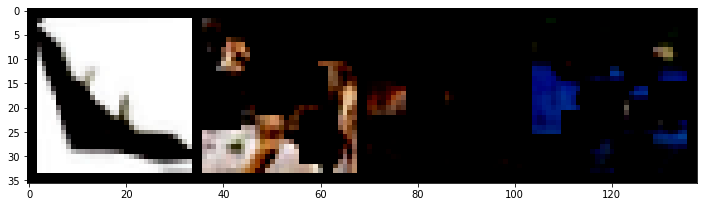

In [10]:
data = DataEngine(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

In [11]:
device = which_device()
# model = Net(args).to(device)
# model = ResNet18().to(device)
model = cifar10Model().to(device)
show_model_summary(model, device, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
           Dropout-3           [-1, 32, 32, 32]               0
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
           Dropout-7           [-1, 64, 32, 32]               0
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,048
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 64, 14, 14]             576
      BatchNorm2d-12           [-1, 64, 14, 14]             128
          Dropout-13           [-1, 64, 14, 14]               0
             ReLU-14           [-1, 64,

In [12]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
# scheduler = OneCycleLR(optimizer,max_lr=0.1,total_steps=20)

In [14]:
trainer = Trainer(model, 
                  device,
                  train_loader=data.train_loader, 
                  test_loader = data.test_loader, 
                  optimizer = optimizer, 
                  loss_func = criterion, 
                  lr_scheduler = None) 

In [15]:
# (train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=args.epochs, lambda_l1=0.0001)
(train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=args.epochs, lambda_l1=0.0001)

Train set: Loss=2.5098068714141846 Batch_id=781 Accuracy=30.05: 100%|██████████| 782/782 [00:20<00:00, 38.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 3877/10000 (38.77%)



Train set: Loss=2.065427780151367 Batch_id=781 Accuracy=40.02: 100%|██████████| 782/782 [00:20<00:00, 38.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 4825/10000 (48.25%)



Train set: Loss=2.2215576171875 Batch_id=781 Accuracy=44.38: 100%|██████████| 782/782 [00:20<00:00, 38.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 5115/10000 (51.15%)



Train set: Loss=2.3458967208862305 Batch_id=781 Accuracy=47.68: 100%|██████████| 782/782 [00:20<00:00, 38.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 5400/10000 (54.00%)



Train set: Loss=2.254944086074829 Batch_id=781 Accuracy=50.84: 100%|██████████| 782/782 [00:20<00:00, 38.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 5822/10000 (58.22%)



Train set: Loss=1.529465675354004 Batch_id=781 Accuracy=52.93: 100%|██████████| 782/782 [00:20<00:00, 38.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 5952/10000 (59.52%)



Train set: Loss=2.4060933589935303 Batch_id=781 Accuracy=54.84: 100%|██████████| 782/782 [00:20<00:00, 38.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 6354/10000 (63.54%)



Train set: Loss=1.6089718341827393 Batch_id=781 Accuracy=56.64: 100%|██████████| 782/782 [00:20<00:00, 37.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 6409/10000 (64.09%)



Train set: Loss=1.2816247940063477 Batch_id=781 Accuracy=57.85: 100%|██████████| 782/782 [00:21<00:00, 37.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 6451/10000 (64.51%)



Train set: Loss=1.4559797048568726 Batch_id=781 Accuracy=59.14: 100%|██████████| 782/782 [00:20<00:00, 37.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0144, Accuracy: 6662/10000 (66.62%)



Train set: Loss=1.8843830823898315 Batch_id=781 Accuracy=60.01: 100%|██████████| 782/782 [00:20<00:00, 38.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 6821/10000 (68.21%)



Train set: Loss=1.4048254489898682 Batch_id=781 Accuracy=61.41: 100%|██████████| 782/782 [00:20<00:00, 37.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 6635/10000 (66.35%)



Train set: Loss=1.6146206855773926 Batch_id=781 Accuracy=62.12: 100%|██████████| 782/782 [00:20<00:00, 37.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 6953/10000 (69.53%)



Train set: Loss=1.5201010704040527 Batch_id=781 Accuracy=63.00: 100%|██████████| 782/782 [00:20<00:00, 38.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0129, Accuracy: 7138/10000 (71.38%)



Train set: Loss=1.6566615104675293 Batch_id=781 Accuracy=63.68: 100%|██████████| 782/782 [00:20<00:00, 38.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 7183/10000 (71.83%)



Train set: Loss=1.2125910520553589 Batch_id=781 Accuracy=64.76: 100%|██████████| 782/782 [00:20<00:00, 38.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 7165/10000 (71.65%)



Train set: Loss=1.2936276197433472 Batch_id=781 Accuracy=64.91: 100%|██████████| 782/782 [00:20<00:00, 38.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 7328/10000 (73.28%)



Train set: Loss=1.2725313901901245 Batch_id=781 Accuracy=65.83: 100%|██████████| 782/782 [00:20<00:00, 37.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 7336/10000 (73.36%)



Train set: Loss=1.3590505123138428 Batch_id=781 Accuracy=66.59: 100%|██████████| 782/782 [00:20<00:00, 38.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 7242/10000 (72.42%)



Train set: Loss=1.2179301977157593 Batch_id=781 Accuracy=67.12: 100%|██████████| 782/782 [00:20<00:00, 38.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 7341/10000 (73.41%)



Train set: Loss=1.0837700366973877 Batch_id=781 Accuracy=66.99: 100%|██████████| 782/782 [00:20<00:00, 38.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 7443/10000 (74.43%)



Train set: Loss=1.6981422901153564 Batch_id=781 Accuracy=67.85: 100%|██████████| 782/782 [00:20<00:00, 37.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 7593/10000 (75.93%)



Train set: Loss=0.9001600742340088 Batch_id=781 Accuracy=68.21: 100%|██████████| 782/782 [00:20<00:00, 37.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 7519/10000 (75.19%)



Train set: Loss=1.4934806823730469 Batch_id=781 Accuracy=68.53: 100%|██████████| 782/782 [00:20<00:00, 37.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 7607/10000 (76.07%)



Train set: Loss=0.8421546816825867 Batch_id=781 Accuracy=68.90: 100%|██████████| 782/782 [00:20<00:00, 37.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 7563/10000 (75.63%)



Train set: Loss=2.123033285140991 Batch_id=781 Accuracy=69.11: 100%|██████████| 782/782 [00:20<00:00, 38.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 7594/10000 (75.94%)



Train set: Loss=1.13584566116333 Batch_id=781 Accuracy=69.38: 100%|██████████| 782/782 [00:20<00:00, 38.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 7734/10000 (77.34%)



Train set: Loss=1.5012956857681274 Batch_id=781 Accuracy=69.61: 100%|██████████| 782/782 [00:20<00:00, 37.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 7766/10000 (77.66%)



Train set: Loss=1.2465587854385376 Batch_id=781 Accuracy=70.38: 100%|██████████| 782/782 [00:20<00:00, 37.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 7864/10000 (78.64%)



Train set: Loss=1.2170794010162354 Batch_id=781 Accuracy=69.96: 100%|██████████| 782/782 [00:20<00:00, 37.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 7818/10000 (78.18%)



Train set: Loss=1.4653903245925903 Batch_id=781 Accuracy=70.62: 100%|██████████| 782/782 [00:20<00:00, 37.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0101, Accuracy: 7775/10000 (77.75%)



Train set: Loss=1.4534964561462402 Batch_id=781 Accuracy=71.06: 100%|██████████| 782/782 [00:20<00:00, 37.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 7818/10000 (78.18%)



Train set: Loss=1.5568104982376099 Batch_id=781 Accuracy=70.81: 100%|██████████| 782/782 [00:20<00:00, 37.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 7759/10000 (77.59%)



Train set: Loss=0.9649457931518555 Batch_id=781 Accuracy=71.08: 100%|██████████| 782/782 [00:20<00:00, 37.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 7868/10000 (78.68%)



Train set: Loss=0.7342944145202637 Batch_id=781 Accuracy=71.39: 100%|██████████| 782/782 [00:20<00:00, 38.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 7809/10000 (78.09%)



Train set: Loss=1.8729169368743896 Batch_id=781 Accuracy=71.64: 100%|██████████| 782/782 [00:20<00:00, 37.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 7768/10000 (77.68%)



Train set: Loss=1.1600559949874878 Batch_id=781 Accuracy=71.49: 100%|██████████| 782/782 [00:20<00:00, 38.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 7752/10000 (77.52%)



Train set: Loss=1.187634825706482 Batch_id=781 Accuracy=71.51: 100%|██████████| 782/782 [00:20<00:00, 37.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 7848/10000 (78.48%)



Train set: Loss=1.6319713592529297 Batch_id=781 Accuracy=71.95: 100%|██████████| 782/782 [00:21<00:00, 37.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 7609/10000 (76.09%)



Train set: Loss=1.2505894899368286 Batch_id=781 Accuracy=71.92: 100%|██████████| 782/782 [00:20<00:00, 37.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 7775/10000 (77.75%)



Train set: Loss=1.2468087673187256 Batch_id=781 Accuracy=72.25: 100%|██████████| 782/782 [00:20<00:00, 37.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 7830/10000 (78.30%)



Train set: Loss=1.9286975860595703 Batch_id=781 Accuracy=72.09: 100%|██████████| 782/782 [00:20<00:00, 37.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 7945/10000 (79.45%)



Train set: Loss=0.9887507557868958 Batch_id=781 Accuracy=72.63: 100%|██████████| 782/782 [00:20<00:00, 37.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 7855/10000 (78.55%)



Train set: Loss=1.2619894742965698 Batch_id=781 Accuracy=72.52: 100%|██████████| 782/782 [00:20<00:00, 37.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 8094/10000 (80.94%)



Train set: Loss=1.1391055583953857 Batch_id=781 Accuracy=72.76: 100%|██████████| 782/782 [00:20<00:00, 37.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 7932/10000 (79.32%)



Train set: Loss=1.475496530532837 Batch_id=781 Accuracy=73.00: 100%|██████████| 782/782 [00:20<00:00, 37.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 7966/10000 (79.66%)



Train set: Loss=1.4451916217803955 Batch_id=781 Accuracy=72.92: 100%|██████████| 782/782 [00:20<00:00, 38.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 7976/10000 (79.76%)



Train set: Loss=1.0219553709030151 Batch_id=781 Accuracy=73.36: 100%|██████████| 782/782 [00:20<00:00, 37.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 7851/10000 (78.51%)



Train set: Loss=1.7080495357513428 Batch_id=781 Accuracy=73.36: 100%|██████████| 782/782 [00:21<00:00, 36.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 8039/10000 (80.39%)



Train set: Loss=1.0819733142852783 Batch_id=781 Accuracy=73.56: 100%|██████████| 782/782 [00:20<00:00, 37.77it/s]



Test set: Average loss: 0.0087, Accuracy: 8071/10000 (80.71%)



In [16]:
(train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=25, lambda_l1=0.0001)

Train set: Loss=1.237134575843811 Batch_id=781 Accuracy=73.52: 100%|██████████| 782/782 [00:20<00:00, 38.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 7787/10000 (77.87%)



Train set: Loss=1.1544342041015625 Batch_id=781 Accuracy=73.70: 100%|██████████| 782/782 [00:20<00:00, 38.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 8126/10000 (81.26%)



Train set: Loss=0.941901683807373 Batch_id=781 Accuracy=73.88: 100%|██████████| 782/782 [00:20<00:00, 37.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 8064/10000 (80.64%)



Train set: Loss=0.8429426550865173 Batch_id=781 Accuracy=74.00: 100%|██████████| 782/782 [00:20<00:00, 38.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 7984/10000 (79.84%)



Train set: Loss=1.0047162771224976 Batch_id=781 Accuracy=74.08: 100%|██████████| 782/782 [00:20<00:00, 37.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 8091/10000 (80.91%)



Train set: Loss=1.4934473037719727 Batch_id=781 Accuracy=74.32: 100%|██████████| 782/782 [00:20<00:00, 38.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 8065/10000 (80.65%)



Train set: Loss=1.1220074892044067 Batch_id=781 Accuracy=74.12: 100%|██████████| 782/782 [00:20<00:00, 38.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 8023/10000 (80.23%)



Train set: Loss=1.0956218242645264 Batch_id=781 Accuracy=74.60: 100%|██████████| 782/782 [00:20<00:00, 38.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 8158/10000 (81.58%)



Train set: Loss=1.6200053691864014 Batch_id=781 Accuracy=74.40: 100%|██████████| 782/782 [00:20<00:00, 37.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 8137/10000 (81.37%)



Train set: Loss=1.6915950775146484 Batch_id=781 Accuracy=74.39: 100%|██████████| 782/782 [00:20<00:00, 37.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 8084/10000 (80.84%)



Train set: Loss=1.3872849941253662 Batch_id=781 Accuracy=74.50: 100%|██████████| 782/782 [00:20<00:00, 37.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 8149/10000 (81.49%)



Train set: Loss=0.8710308074951172 Batch_id=781 Accuracy=74.49: 100%|██████████| 782/782 [00:20<00:00, 37.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 8142/10000 (81.42%)



Train set: Loss=1.1761763095855713 Batch_id=781 Accuracy=74.89: 100%|██████████| 782/782 [00:20<00:00, 37.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 8106/10000 (81.06%)



Train set: Loss=1.0210959911346436 Batch_id=781 Accuracy=74.98: 100%|██████████| 782/782 [00:20<00:00, 37.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 8124/10000 (81.24%)



Train set: Loss=0.505698561668396 Batch_id=781 Accuracy=75.14: 100%|██████████| 782/782 [00:20<00:00, 38.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 8088/10000 (80.88%)



Train set: Loss=0.9126601219177246 Batch_id=781 Accuracy=74.87: 100%|██████████| 782/782 [00:20<00:00, 37.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 8192/10000 (81.92%)



Train set: Loss=1.2152016162872314 Batch_id=781 Accuracy=75.28: 100%|██████████| 782/782 [00:20<00:00, 37.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 8117/10000 (81.17%)



Train set: Loss=0.6245834827423096 Batch_id=781 Accuracy=75.27: 100%|██████████| 782/782 [00:21<00:00, 37.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 8045/10000 (80.45%)



Train set: Loss=0.8357681035995483 Batch_id=781 Accuracy=75.41: 100%|██████████| 782/782 [00:20<00:00, 37.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 8289/10000 (82.89%)



Train set: Loss=1.1960835456848145 Batch_id=781 Accuracy=75.63: 100%|██████████| 782/782 [00:20<00:00, 37.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 8185/10000 (81.85%)



Train set: Loss=1.4804625511169434 Batch_id=781 Accuracy=75.44: 100%|██████████| 782/782 [00:20<00:00, 37.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 8057/10000 (80.57%)



Train set: Loss=1.0623972415924072 Batch_id=781 Accuracy=75.48: 100%|██████████| 782/782 [00:20<00:00, 37.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 8165/10000 (81.65%)



Train set: Loss=1.238727331161499 Batch_id=781 Accuracy=75.65: 100%|██████████| 782/782 [00:20<00:00, 37.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 8123/10000 (81.23%)



Train set: Loss=1.3380318880081177 Batch_id=781 Accuracy=75.57: 100%|██████████| 782/782 [00:21<00:00, 36.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 8228/10000 (82.28%)



Train set: Loss=1.0717291831970215 Batch_id=781 Accuracy=75.59: 100%|██████████| 782/782 [00:20<00:00, 37.58it/s]



Test set: Average loss: 0.0079, Accuracy: 8264/10000 (82.64%)



In [28]:
(train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=25, lambda_l1=0.0001)

Train set: Loss=1.440110206604004 Batch_id=781 Accuracy=75.87: 100%|██████████| 782/782 [00:21<00:00, 37.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 8008/10000 (80.08%)



Train set: Loss=0.9875909686088562 Batch_id=781 Accuracy=75.81: 100%|██████████| 782/782 [00:21<00:00, 37.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 8161/10000 (81.61%)



Train set: Loss=1.0090293884277344 Batch_id=781 Accuracy=75.92: 100%|██████████| 782/782 [00:21<00:00, 37.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 8190/10000 (81.90%)



Train set: Loss=0.8793152570724487 Batch_id=781 Accuracy=76.09: 100%|██████████| 782/782 [00:21<00:00, 37.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 8248/10000 (82.48%)



Train set: Loss=0.5991232991218567 Batch_id=781 Accuracy=76.39: 100%|██████████| 782/782 [00:21<00:00, 37.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 8203/10000 (82.03%)



Train set: Loss=1.1947484016418457 Batch_id=781 Accuracy=76.17: 100%|██████████| 782/782 [00:21<00:00, 36.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 8108/10000 (81.08%)



Train set: Loss=0.8813806176185608 Batch_id=781 Accuracy=76.32: 100%|██████████| 782/782 [00:21<00:00, 37.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 8245/10000 (82.45%)



Train set: Loss=1.2352371215820312 Batch_id=781 Accuracy=76.22: 100%|██████████| 782/782 [00:21<00:00, 37.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 8339/10000 (83.39%)



Train set: Loss=0.9750810861587524 Batch_id=781 Accuracy=76.24: 100%|██████████| 782/782 [00:21<00:00, 37.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 8227/10000 (82.27%)



Train set: Loss=1.55037260055542 Batch_id=781 Accuracy=76.42: 100%|██████████| 782/782 [00:21<00:00, 36.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 8172/10000 (81.72%)



Train set: Loss=0.8782303333282471 Batch_id=781 Accuracy=76.30: 100%|██████████| 782/782 [00:21<00:00, 36.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8291/10000 (82.91%)



Train set: Loss=1.0770564079284668 Batch_id=781 Accuracy=76.80: 100%|██████████| 782/782 [00:21<00:00, 36.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8315/10000 (83.15%)



Train set: Loss=0.8867902755737305 Batch_id=781 Accuracy=76.79: 100%|██████████| 782/782 [00:21<00:00, 36.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 8400/10000 (84.00%)



Train set: Loss=1.2487671375274658 Batch_id=781 Accuracy=76.46: 100%|██████████| 782/782 [00:21<00:00, 36.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 8197/10000 (81.97%)



Train set: Loss=1.1703338623046875 Batch_id=781 Accuracy=76.46: 100%|██████████| 782/782 [00:21<00:00, 36.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 8354/10000 (83.54%)



Train set: Loss=0.8071914315223694 Batch_id=781 Accuracy=77.00: 100%|██████████| 782/782 [00:21<00:00, 36.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8350/10000 (83.50%)



Train set: Loss=0.9424532055854797 Batch_id=781 Accuracy=76.97: 100%|██████████| 782/782 [00:21<00:00, 36.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8325/10000 (83.25%)



Train set: Loss=1.1468751430511475 Batch_id=781 Accuracy=76.64: 100%|██████████| 782/782 [00:21<00:00, 36.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8390/10000 (83.90%)



Train set: Loss=0.7076010704040527 Batch_id=781 Accuracy=76.94: 100%|██████████| 782/782 [00:21<00:00, 37.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 8396/10000 (83.96%)



Train set: Loss=1.2207133769989014 Batch_id=781 Accuracy=76.97: 100%|██████████| 782/782 [00:21<00:00, 36.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 8196/10000 (81.96%)



Train set: Loss=1.0282292366027832 Batch_id=781 Accuracy=77.03: 100%|██████████| 782/782 [00:21<00:00, 36.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8381/10000 (83.81%)



Train set: Loss=1.0377411842346191 Batch_id=781 Accuracy=76.85: 100%|██████████| 782/782 [00:21<00:00, 36.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8395/10000 (83.95%)



Train set: Loss=1.0343390703201294 Batch_id=781 Accuracy=77.02: 100%|██████████| 782/782 [00:21<00:00, 36.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8348/10000 (83.48%)



Train set: Loss=1.1401947736740112 Batch_id=781 Accuracy=77.19: 100%|██████████| 782/782 [00:21<00:00, 36.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8372/10000 (83.72%)



Train set: Loss=1.270491123199463 Batch_id=781 Accuracy=76.95: 100%|██████████| 782/782 [00:21<00:00, 36.88it/s]



Test set: Average loss: 0.0076, Accuracy: 8291/10000 (82.91%)



In [40]:
(train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=25, lambda_l1=0.0001)

Train set: Loss=1.1751238107681274 Batch_id=781 Accuracy=77.52: 100%|██████████| 782/782 [00:21<00:00, 36.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8349/10000 (83.49%)



Train set: Loss=0.9243988394737244 Batch_id=781 Accuracy=77.30: 100%|██████████| 782/782 [00:21<00:00, 36.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 8199/10000 (81.99%)



Train set: Loss=1.510205626487732 Batch_id=781 Accuracy=77.31: 100%|██████████| 782/782 [00:21<00:00, 36.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8418/10000 (84.18%)



Train set: Loss=0.9173794984817505 Batch_id=781 Accuracy=77.20: 100%|██████████| 782/782 [00:21<00:00, 36.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8350/10000 (83.50%)



Train set: Loss=1.2836776971817017 Batch_id=781 Accuracy=77.66: 100%|██████████| 782/782 [00:21<00:00, 37.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8422/10000 (84.22%)



Train set: Loss=1.275047779083252 Batch_id=781 Accuracy=77.68: 100%|██████████| 782/782 [00:21<00:00, 36.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8402/10000 (84.02%)



Train set: Loss=1.0820095539093018 Batch_id=781 Accuracy=77.53: 100%|██████████| 782/782 [00:21<00:00, 36.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 8409/10000 (84.09%)



Train set: Loss=0.946259617805481 Batch_id=781 Accuracy=77.71: 100%|██████████| 782/782 [00:21<00:00, 36.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8467/10000 (84.67%)



Train set: Loss=1.3023614883422852 Batch_id=781 Accuracy=77.73: 100%|██████████| 782/782 [00:21<00:00, 36.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8440/10000 (84.40%)



Train set: Loss=0.8699346780776978 Batch_id=781 Accuracy=77.58: 100%|██████████| 782/782 [00:21<00:00, 36.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8413/10000 (84.13%)



Train set: Loss=1.2650389671325684 Batch_id=781 Accuracy=77.74: 100%|██████████| 782/782 [00:21<00:00, 35.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 8395/10000 (83.95%)



Train set: Loss=1.2771227359771729 Batch_id=781 Accuracy=77.65: 100%|██████████| 782/782 [00:21<00:00, 36.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8465/10000 (84.65%)



Train set: Loss=0.9642968773841858 Batch_id=781 Accuracy=77.57: 100%|██████████| 782/782 [00:21<00:00, 36.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 8368/10000 (83.68%)



Train set: Loss=1.5559046268463135 Batch_id=781 Accuracy=77.84: 100%|██████████| 782/782 [00:21<00:00, 35.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 8326/10000 (83.26%)



Train set: Loss=0.6804823279380798 Batch_id=781 Accuracy=77.93: 100%|██████████| 782/782 [00:21<00:00, 36.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8354/10000 (83.54%)



Train set: Loss=0.9280620813369751 Batch_id=781 Accuracy=78.15: 100%|██████████| 782/782 [00:21<00:00, 36.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8484/10000 (84.84%)



Train set: Loss=1.0500586032867432 Batch_id=781 Accuracy=78.23: 100%|██████████| 782/782 [00:21<00:00, 36.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 8337/10000 (83.37%)



Train set: Loss=0.902798056602478 Batch_id=781 Accuracy=78.06: 100%|██████████| 782/782 [00:21<00:00, 36.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8456/10000 (84.56%)



Train set: Loss=0.639917254447937 Batch_id=781 Accuracy=77.69: 100%|██████████| 782/782 [00:21<00:00, 36.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 8362/10000 (83.62%)



Train set: Loss=1.0772759914398193 Batch_id=781 Accuracy=78.01: 100%|██████████| 782/782 [00:21<00:00, 36.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 8481/10000 (84.81%)



Train set: Loss=1.0697247982025146 Batch_id=781 Accuracy=77.95: 100%|██████████| 782/782 [00:21<00:00, 36.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 8514/10000 (85.14%)



Train set: Loss=0.7930605411529541 Batch_id=781 Accuracy=78.12: 100%|██████████| 782/782 [00:21<00:00, 35.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 8472/10000 (84.72%)



Train set: Loss=0.8552464246749878 Batch_id=781 Accuracy=78.19: 100%|██████████| 782/782 [00:22<00:00, 35.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 8516/10000 (85.16%)



Train set: Loss=1.0331029891967773 Batch_id=781 Accuracy=78.20: 100%|██████████| 782/782 [00:21<00:00, 35.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8483/10000 (84.83%)



Train set: Loss=0.8657135963439941 Batch_id=781 Accuracy=78.17: 100%|██████████| 782/782 [00:21<00:00, 36.05it/s]



Test set: Average loss: 0.0068, Accuracy: 8546/10000 (85.46%)



In [41]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
			'frog', 'horse', 'ship', 'truck')

In [42]:
trainer.classwise_acc(classes)


Accuracy of plane : 94 %
Accuracy of   car : 84 %
Accuracy of  bird : 74 %
Accuracy of   cat : 76 %
Accuracy of  deer : 89 %
Accuracy of   dog : 67 %
Accuracy of  frog : 85 %
Accuracy of horse : 81 %
Accuracy of  ship : 90 %
Accuracy of truck : 93 %



In [43]:
misclassified_imgs = trainer.get_misclassified()

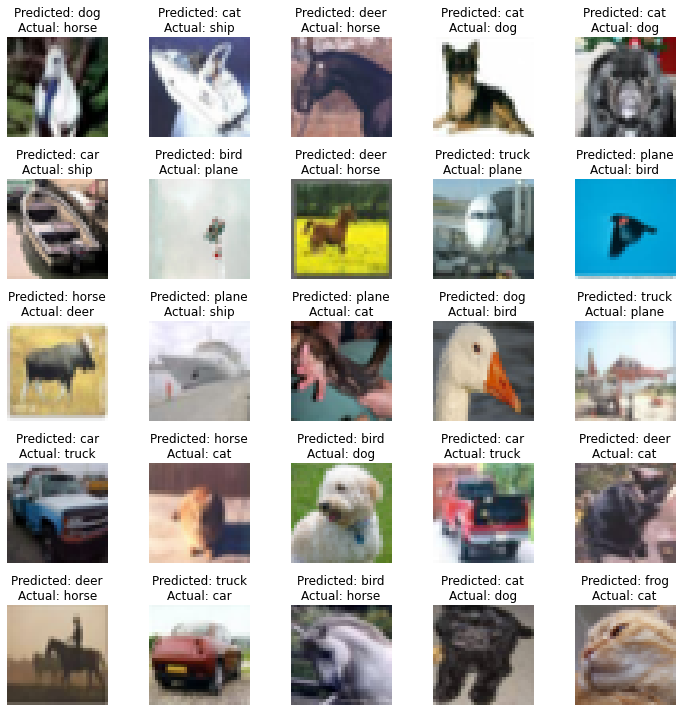

In [44]:
plot_misclassified_images(misclassified_imgs, classes, "misclassified_images1.png")

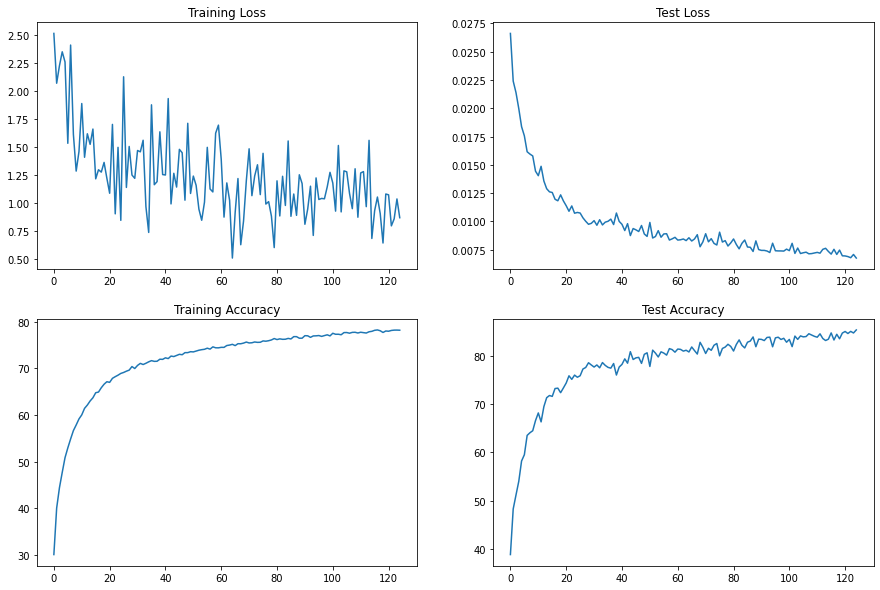

In [45]:
from results import plot_metrics
plot_metrics(train_loss, train_acc, test_loss, test_acc)

In [46]:
### GradCam

In [47]:
dataiter = iter(data.test_loader)
images, labels = dataiter.next()

In [48]:
import PIL
import numpy as np

In [49]:
# model.convblock

In [50]:
def plot_images_gradcam(torch_img,normed_torch_img, model):
    images=[]
    g1 = GradCAM(model, model.convblock8)
    g2 = GradCAM(model, model.convblock7)
    g3 = GradCAM(model, model.convblock6)
    g4 = GradCAM(model, model.convblock5)
    mask1, _ = g1(normed_torch_img)
    mask2, _ = g2(normed_torch_img)
    mask3, _ = g3(normed_torch_img)
    mask4, _ = g4(normed_torch_img)
    heatmap1, result1 = visualize_cam(mask1, torch_img)
    heatmap2, result2 = visualize_cam(mask2, torch_img)
    heatmap3, result3 = visualize_cam(mask3, torch_img)
    heatmap4, result4 = visualize_cam(mask4, torch_img)

    images.extend([torch_img.cpu(), heatmap1, heatmap2, heatmap3, heatmap4])
    images.extend([torch_img.cpu(), result1, result2, result3, result4])
    grid_image = make_grid(images, nrow=5)
    imshow(grid_image)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


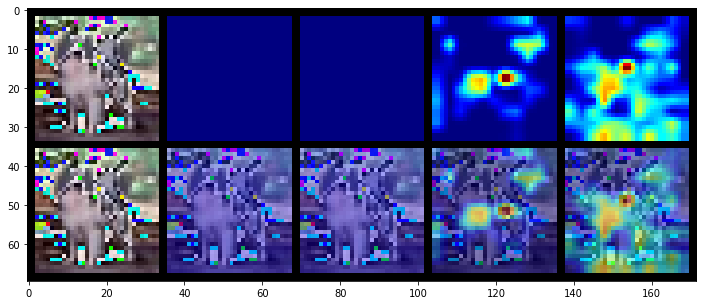

In [51]:
trans = transforms.ToPILImage()
pil_img=trans(torchvision.utils.make_grid(images[1]))
torch_img,normed_torch_img=change(pil_img,device)
plot_images_gradcam(torch_img,normed_torch_img, model)